In [23]:
import numpy as np
import pandas as pd
import json
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle as pkl
import imblearn
from sklearn.datasets import load_boston
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import sys                                               
from impyute.imputation.cs import fast_knn
import imblearn                                      
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
import sklearn
import xgboost
from xgboost import XGBClassifier            
from xgboost import XGBRegressor
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from xgboost import cv
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn import svm
import sklearn.gaussian_process as gp

In [46]:
excel = pd.ExcelFile('Coronna Data CERTAIN with KVB edits.xlsx')
df = pd.read_excel(excel, 'BL+3M')

In [47]:
df = df.drop(columns = ['SubjectID', 'CDate', 'Match'])    ### Unique values
df = df.drop(columns = ['SubjectID.1', 'UNMC_id.1', 'CDate.1', 'init_group.1', 'grp.1', 'UNMC_id.2', 'grp.2', 'init_group.2', 'CDate.1', 'futime.1'])    ### Duplicate values
df = df.drop(columns = ['init_group', 'futime'])    ### same values for all rows

In [48]:
df = df.drop(columns = ['statin_use', 'rfstatus_impute', 'ccpstatus_impute', 'statin_use.1', 'smkyrs', 'numcigs'])  ### Dropping columns who have null values greater than 70%

In [49]:
df = df.rename(columns={"usresultsIgA.1": "usresultsIgA_BL", "usresultsIgG.1": "usresultsIgG_BL", "usresultsIgM.1": "usresultsIgM_BL", 'seatedbp1.1': 'seatedbp1_BL',
                              'seatedbp2.1': 'seatedbp2_BL', 'pres_mtx.1': 'pres_mtx_BL', 'pres_arava.1': 'pres_arava_BL', 'pres_azulfidine.1': 'pres_azulfidine_BL', 
                              'pres_plaquenil.1': 'pres_plaquenil_BL', 'pres_imuran.1': 'pres_imuran_BL', 'pres_minocin.1': 'pres_minocin_BL', 'pres_pred.1': 'pres_pred_BL',
                              'statin_use.1': 'statin_use_BL', 'tender_jts_28.1': 'tender_jts_28_BL', 'BLswollen_jts_28': 'swollen_jts_28_BL',
                              'BLmd_global_assess': 'md_global_assess_BL', 'BLpt_global_assess': 'pt_global_assess_BL', 'BLdi': 'di_BL', 'BLpt_pain': 'pt_pain_BL', 'BLusresultsCRP': 'usresultsCRP_BL',
                              'DAS28-CRP BL': 'DAS28-CRP_BL', })     ### Renaming some columns. Not sure why - did it because previous student did it

In [50]:
df = df.drop(columns = ['seatedbp1', 'seatedbp2', 'pres_mtx', 'pres_arava', 'pres_azulfidine', 'pres_plaquenil',
                           'pres_pred', 'md_global_assess', 'pt_global_assess', 'di', 'pt_pain', 'usresultsIgA', 
                           'usresultsIgG', 'usresultsIgM'])

In [51]:
df = df.drop('UNMC_id',1)
final_df = df
model_label = LabelEncoder()
final_df['grp'] = model_label.fit_transform(final_df['grp'].astype('str'))
final_df['gender'] = model_label.fit_transform(final_df['gender'].astype('str'))
final_df['final_education'] = model_label.fit_transform(final_df['final_education'].astype('str'))
final_df['race_grp'] = model_label.fit_transform(final_df['race_grp'].astype('str'))
final_df['newsmoker'] = model_label.fit_transform(final_df['newsmoker'].astype('str'))
final_df['drinker'] = model_label.fit_transform(final_df['drinker'].astype('str'))
final_df['ara_func_class'] = model_label.fit_transform(final_df['ara_func_class'].astype('str'))

<ipython-input-51-f80c6ef2a649>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('UNMC_id',1)


In [52]:
final_df = final_df[final_df['DAS28-CRP 3m'].notnull()]

In [53]:
rs = 1337
X = final_df.drop('DAS28-CRP 3m',1)                            ### Dividing the dataframe into X and y set
y = final_df['DAS28-CRP 3m']
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.1,random_state = rs)


<ipython-input-53-cbd1a78ea90f>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X = final_df.drop('DAS28-CRP 3m',1)                            ### Dividing the dataframe into X and y set


In [54]:
train_das = X_train['DAS28-CRP_BL']
train_3m = X_train['3MResponse']
test_das = X_test['DAS28-CRP_BL']
test_3m = X_test['3MResponse']
X_train = X_train.drop('DAS28-CRP_BL',1)
X_train = X_train.drop('3MResponse',1)
X_test = X_test.drop('DAS28-CRP_BL',1)
X_test = X_test.drop('3MResponse',1)

<ipython-input-54-f1739b216d05>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = X_train.drop('DAS28-CRP_BL',1)
<ipython-input-54-f1739b216d05>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = X_train.drop('3MResponse',1)
<ipython-input-54-f1739b216d05>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = X_test.drop('DAS28-CRP_BL',1)
<ipython-input-54-f1739b216d05>:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = X_test.drop('3MResponse',1)


In [55]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=15)                     ### Imputing the null values using KNN with neighbors as 15
fit_train = imputer.fit(X_train)
imput_train = fit_train.transform(X_train)
c = list(X_train.columns)
imput_train_df = pd.DataFrame(imput_train, columns = c)

In [56]:
imput_test = fit_train.transform(X_test)                 ### Imputing the test set using the training set
c = list(X_test.columns)
imput_test_df = pd.DataFrame(imput_test, columns = c)

In [57]:
labels = ['grp','gender','final_education','race_grp','newsmoker','drinker','ara_func_class']     ### normalizing the dataset

for i in imput_train_df.columns:
    if i not in labels:
        mean = imput_train_df[i].mean()
        std = imput_train_df[i].std()
        imput_train_df[i] = (imput_train_df[i] - mean) / std
        imput_test_df[i] = (imput_test_df[i] - mean) / std

In [58]:
labels = ['pres_imuran','pres_minocin','num_tnf','num_nontnf','hxunstab_ang','pres_minocin_BL','ethnicity','hxstroke','pres_imuran_BL']    #### This columns has same value for every row so when I divide by mean and std the value goes to infinity
for i in labels:
    imput_train_df = imput_train_df.drop(i,1)
    imput_test_df = imput_test_df.drop(i,1)

<ipython-input-58-649ae34e813e>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  imput_train_df = imput_train_df.drop(i,1)
<ipython-input-58-649ae34e813e>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  imput_test_df = imput_test_df.drop(i,1)


[2.00833835 4.43480425 3.47251208 4.10144789 2.65006424 1.71659124
 2.34894489 3.10200262 2.65767942 2.22817168 2.01889788 2.77581941
 2.78988205 2.86824819 3.29086015 2.19467767 3.18176373 2.57566737
 2.18801458 3.3531775  1.91980679 3.38465355 2.00667217 5.11028481
 2.32009013 3.25145131 2.58539387 3.52789968]
Mean squared error: 0.22457049016946043 Root Mean squared error: 0.4738886896407852
Validation accuracy is 0.7394991161402362
Training accuracy is 0.8682391926842955
Testing accuracy is 0.7765942273411557
[0.8060179451788347, 0.1420280912489824, 0.11115258835908123, 0.015844873274604366, 0.015388858729171484, 0.01522196979253917, 0.011703219632694838, 0.011370871582193432, 0.011360710496224325, 0.010082469869941046]


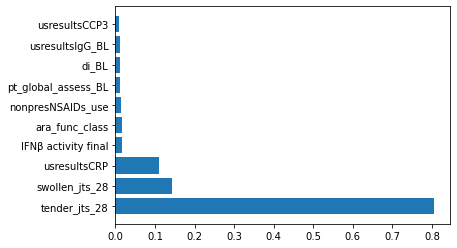

In [15]:
ridge_reg = None
preds_rr = None
arr_x = []
arr_y = []
def ridge_reg(X_train, X_test, Y_train,Y_test):
    global ridge_reg
    global preds_rr
    ridge_reg = sklearn.linear_model.Ridge(random_state = rs)
    ridge_reg.fit(X_train, Y_train)
    results = cross_val_score(ridge_reg, X_train, Y_train, cv=10, scoring="r2")
    preds_rr = ridge_reg.predict(X_test)
    print("Mean squared error:", mean_squared_error(Y_test,preds),"Root Mean squared error:", np.sqrt(mean_squared_error(Y_test,preds)))
    print("Validation accuracy is", results.mean())
    print(f"Training accuracy is {ridge_reg.score(X_train, Y_train)}")
    print(f"Testing accuracy is {ridge_reg.score(X_test, Y_test)}")
    result = permutation_importance(ridge_reg, X_train, Y_train, n_repeats=10, random_state=0, n_jobs=2)
    sorted_index = result.importances_mean.argsort()
    top10 = sorted_index[-10:]
    feature_names = list(X_train.columns)
    top10 = top10[::-1]
    global arr_x
    global arr_y
    arr_x = []
    arr_y = []
    for i in top10:
        arr_x.append( result.importances_mean[i])
        arr_y.append(feature_names[i])
    print(arr_x)
    plt.barh(arr_y, arr_x)
    plt.show()
ridge_reg(imput_train_df, imput_test_df,Y_train, Y_test)

C:\Users\valay\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\valay\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\valay\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\valay\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\valay\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\valay\anaconda3\lib\site-packages\sklearn\base.py:441: U

C:\Users\valay\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\valay\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\valay\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\valay\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\valay\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\valay\anaconda3\lib\site-packages\sklearn\base.py:441: U

prediction [1.4857822  4.44262818 3.1833974  4.25808007 2.83189446 1.61046948
 2.8755064  3.45857145 1.6133867  2.20154994 2.8230505  1.81186329
 3.47537931 3.23240406 3.39668945 1.46683239 2.46539375 2.6256946
 2.52511573 2.22075258 2.03565133 3.55002905 1.55102463 5.10208303
 2.68432023 3.22881739 2.34886235 3.18625159]
Mean squared error: 0.15280421028818258 Root Mean squared error: 0.39090179110383033
Validation accuracy is: 0.8838214781990074
Training accuracy is 0.9548649438866114
Testing accuracy is 0.8479882969521241
[1.1684709230515369, 0.14837501183925528, 0.09747753355459336, 0.015667763520357057, 0.006343866502004436, 0.0030508123093313743, 0.0025884868249523964, 0.0020223897798980484, 0.0017542836591618815, 0.001485922176486787]


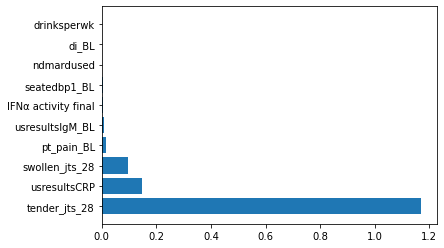

In [59]:
from sklearn.ensemble import StackingRegressor
st_reg = None
preds_sr = None
arr_y_sr = []
def stacking_regressor(X_train, X_test,Y_train, Y_test):
    global st_reg
    global preds_sr
    rr = sklearn.linear_model.Ridge(random_state = rs)
    SVR = svm.SVR(kernel = 'rbf')
    xgb = XGBRegressor(n_estimators = 200, subsample=0.8, max_depth=50, eta=0.5, gamma=1, min_child_weight=10, alpha=1, random_state=rs)   
    rf = sklearn.ensemble.RandomForestRegressor(n_estimators=474, oob_score = True, criterion='squared_error',max_depth=90, min_samples_split=10, max_features='auto', min_samples_leaf = 6, random_state = rs)
    NB = gp.GaussianProcessRegressor(n_restarts_optimizer=10, alpha=0.1, normalize_y=True)
    #knn = KNeighborsRegressor(n_neighbors=10)
    st_reg = StackingRegressor(estimators =[('xgb',xgb),('rf',rf),('svr',SVR),('NB',NB)], final_estimator = rr)
    st_reg = st_reg.fit(X_train, Y_train)
    kfold = StratifiedKFold(n_splits=10)
    results = cross_val_score(st_reg, X_train, Y_train, cv=10)
    preds_sr = st_reg.predict(X_test)
    print("prediction",preds2)
    print("Mean squared error:", mean_squared_error(Y_test,preds2),"Root Mean squared error:", np.sqrt(mean_squared_error(Y_test,preds2)))
    print("Validation accuracy is:", results.mean())
    print(f"Training accuracy is {st_reg.score(X_train, Y_train)}")
    print(f"Testing accuracy is {st_reg.score(X_test, Y_test)}")
    result = permutation_importance(st_reg, X_train, Y_train, n_repeats=10, random_state=0, n_jobs=2)
    sorted_index = result.importances_mean.argsort()
    top10 = sorted_index[-10:]
    feature_names = list(X_train.columns)
    top10 = top10[::-1]
    arr_x = []
    global arr_y_sr
    #arr_y = []
    for i in top10:
        arr_x.append( result.importances_mean[i])
        arr_y_sr.append(feature_names[i])
    print(arr_x)
    plt.barh(arr_y_sr, arr_x)
    plt.show()
stacking_regressor(imput_train_df, imput_test_df,Y_train, Y_test)

C:\Users\valay\anaconda3\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[1.73121252 4.24917232 3.16323212 4.31834074 2.83357443 1.7533584
 3.12797376 3.34520466 1.76824246 2.23543846 3.01888806 1.78793846
 3.17636489 2.78524876 3.47720825 1.59298906 2.35101464 2.54577226
 2.9642925  2.51741269 2.34447659 3.40406179 1.64058132 4.99137928
 2.89479859 3.38527813 2.37707721 3.32490391]
Mean squared error: 0.15580875990862988 Root Mean squared error: 0.39472618345966093
Validation accuracy is 0.8704557351653949
Training accuracy is 0.9427481154553584
Testing accuracy is 0.8449993301963347
[1.3810829330331569, 0.10635964925744545, 0.0413617212086498, 0.007214504701981572, 0.00441276268968287, 0.0023048537080840314, 0.0017527207649705944, 0.0016549761747088221, 0.0013781322410338804, 0.0013525713600840649]


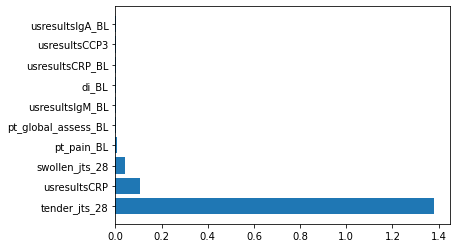

In [17]:
rf_model = None
preds_rf = None
def random_forest(X_train, X_test, Y_train,Y_test):
    global rf_model
    rf_model = sklearn.ensemble.RandomForestRegressor(n_estimators=474, oob_score = True, criterion='squared_error',max_depth=90, min_samples_split=10, random_state=rs, max_features='auto', min_samples_leaf = 6)
    rf_model.fit(X_train, Y_train)
    global preds_rf
    preds_rf = rf_model.predict(X_test)
    
    print(preds1)
    print("Mean squared error:", mean_squared_error(Y_test,preds1),"Root Mean squared error:", np.sqrt(mean_squared_error(Y_test,preds1)))
    print("Validation accuracy is", rf_model.oob_score_)
    print(f"Training accuracy is {rf_model.score(X_train, Y_train)}")
    print(f"Testing accuracy is {rf_model.score(X_test, Y_test)}")
    result = permutation_importance(rf_model, X_train, Y_train, n_repeats=10, random_state=0, n_jobs=2)
    sorted_index = result.importances_mean.argsort()
    top10 = sorted_index[-10:]
    feature_names = list(X_train.columns)
    top10 = top10[::-1]
    arr_x = []
    arr_y = []
    for i in top10:
        arr_x.append( result.importances_mean[i])
        arr_y.append(feature_names[i])
    print(arr_x)
    plt.barh(arr_y, arr_x)
    plt.show()
random_forest(imput_train_df, imput_test_df,Y_train, Y_test)

In [38]:
for i in range(len(test_3m)):
    #print(test_3m.iloc[i])
    if test_3m.iloc[i] == "Good":
        test_3m.iloc[i] = 2
    elif test_3m.iloc[i] == "Moderate":
        test_3m.iloc[i] = 1
    else:
        test_3m.iloc[i] = 0
        

In [42]:
Y_test1 = Y_test.reset_index()
Y_test1 = Y_test1.drop(columns=['index'])
imput_test_df['actual'] = Y_test1
imput_test_df['preds'] = preds_rr                        ### change here the preds_xx variable in order to replace the prediction values for different models
Y_test2 = test_das.reset_index()
Y_test2 = Y_test2.drop(columns=['index'])
imput_test_df['das'] = Y_test2
Y_test3 = test_3m.reset_index()
Y_test3 = Y_test3.drop(columns=['index'])
imput_test_df['3m'] = Y_test3

In [44]:
def responseClassify(row):
    
    change = abs(row['das'] - row['preds'] )
    #print(change)
    if row['preds'] > 5.1:
        #return 2
        if change > 1.2:
            return 0
        elif (change > 0.6) & (change <= 1.2):
            return 2
        elif change <= 0.6:
            return 2
    elif (row['preds'] <= 5.1) & (row['preds'] > 3.2):
        #return 1
        if change > 1.2:
            return 0
        elif (change > 0.6) & (change <= 1.2):
            return 0
        elif change <= 0.6:
            return 2
    elif row['preds'] < 3.2:
        #return 0
        if change > 1.2:
            return 1
        elif (change > 0.6) & (change <= 1.2):
            return 0
        elif change <= 0.6:
            return 2


In [43]:
def responseClassify_original(row):
    
    change = abs(row['das'] - row['preds'] )
    if change > 1.2:
        return 2
    elif (change > 0.6) & (change <= 1.2):
        return 1
    elif change <= 0.6:
        return 0


In [ ]:
imput_test_df['prediction_response'] = imput_test_df.apply(lambda row: responseClassify_original(row), axis = 1)

In [45]:
print(list(imput_test_df['prediction_response']))
count = 0
for i in range(len(imput_test_df['prediction_response'])):
    if imput_test_df['prediction_response'][i] == imput_test_df['3m'][i]:
        count += 1
print(count/28)

[2, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2]
0.7142857142857143
